In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree 
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import plotly.express as px

sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'xgboost'

In [1]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:03
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel('/home/abdel/Documents/DOTNET_Project/Data backup/DataRepo/TEST/merged_revs.xlsx')

# Exploratory Data Analysis

In [4]:
df.head()

,Unnamed: 0,month,rate,title,review,name,city
0,0,April 2012,5,"Unique, large & helpful",We stayed here for a few nights after staying ...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes
1,1,December 2012,5,The Best Riad in Fez,My wife and I were in Morocco for about 10 day...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes
2,2,December 2012,4,Gorgeous restoration,We loved the staff here! This gorgeous restora...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes
3,3,October 2012,5,"Beautiful, perfect, amazing.",I feel like the other reviewers have already s...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes
4,4,January 2013,5,Perfection,Truly beautiful Riad and service exceptional.A...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes


In [6]:
df = df.drop('Unnamed: 0',axis=1) 

In [7]:
df.isna().sum()

month         0
rate          0
title         1
review        0
name          0
city      14560
dtype: int64

**Review Count Visual**

Text(0.5, 1.0, 'Review Count by Rating')

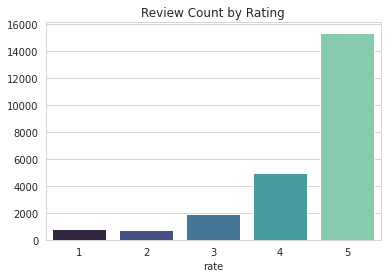

In [8]:
grouped = df.groupby('rate')['rate'].count()
sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')

After plotting review count per rating, it is evident that there is a class imbalance. By group together ratings of 1 and 2, ratings of 3 and 4, and rating 5, the class imbalance should be reduced.

In [9]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['rate'].apply(new_rating)

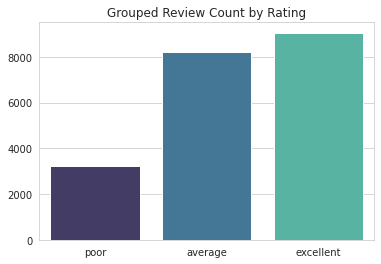

In [11]:
new_rating_grouped = df.groupby('new_rating')['rate'].count()
new_rating_grouped
ax = sns.barplot(x = ['poor','average','excellent'], y = [3214, 8223, 9054], palette='mako').set_title('Grouped Review Count by Rating')

The class imbalance is less prominent now, but there are still less "poor" review types. This will be accounted for by using the class_weight="balanced" parameter in the models.

**Word Count Graph**

Text(0.5, 1.0, 'Word Count by Review')

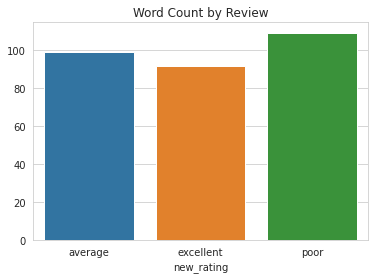

In [14]:
df['words'] = [x.split() for x in df['review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

This graph shows that the larger the word count, the worse the review. It is worth considering including this feature in the modeling process.

# Preprocessing

Functions will be used on the "Reviews" column in order to prepare the data for modeling.

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
sw = stopwords.words('english')

In [18]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [32]:
df['tokenized'] = df['review'].apply(doc_preparer)

In [33]:
df.head()

,month,rate,title,review,name,city,new_rating,words,word_count,tokenized
0,April 2012,5,"Unique, large & helpful",We stayed here for a few nights after staying ...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes,excellent,"[We, stayed, here, for, a, few, nights, after,...",144,stay night stay moroccan family heaven say man...
1,December 2012,5,The Best Riad in Fez,My wife and I were in Morocco for about 10 day...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes,excellent,"[My, wife, and, I, were, in, Morocco, for, abo...",153,wife morocco day day marrakech day fez love fe...
2,December 2012,4,Gorgeous restoration,We loved the staff here! This gorgeous restora...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes,average,"[We, loved, the, staff, here!, This, gorgeous,...",140,loved staff gorgeous restoration former iman b...
3,October 2012,5,"Beautiful, perfect, amazing.",I feel like the other reviewers have already s...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes,excellent,"[I, feel, like, the, other, reviewers, have, a...",145,feel like reviewer already sum well perfection...
4,January 2013,5,Perfection,Truly beautiful Riad and service exceptional.A...,Hotel_Spa_Riad_Dar_Bensouda,Fes_Fes_Meknes,excellent,"[Truly, beautiful, Riad, and, service, excepti...",78,truly beautiful riad service exceptional staff...


# Exploratory Data Analysis Continued

**Frequency Distribution on Words**

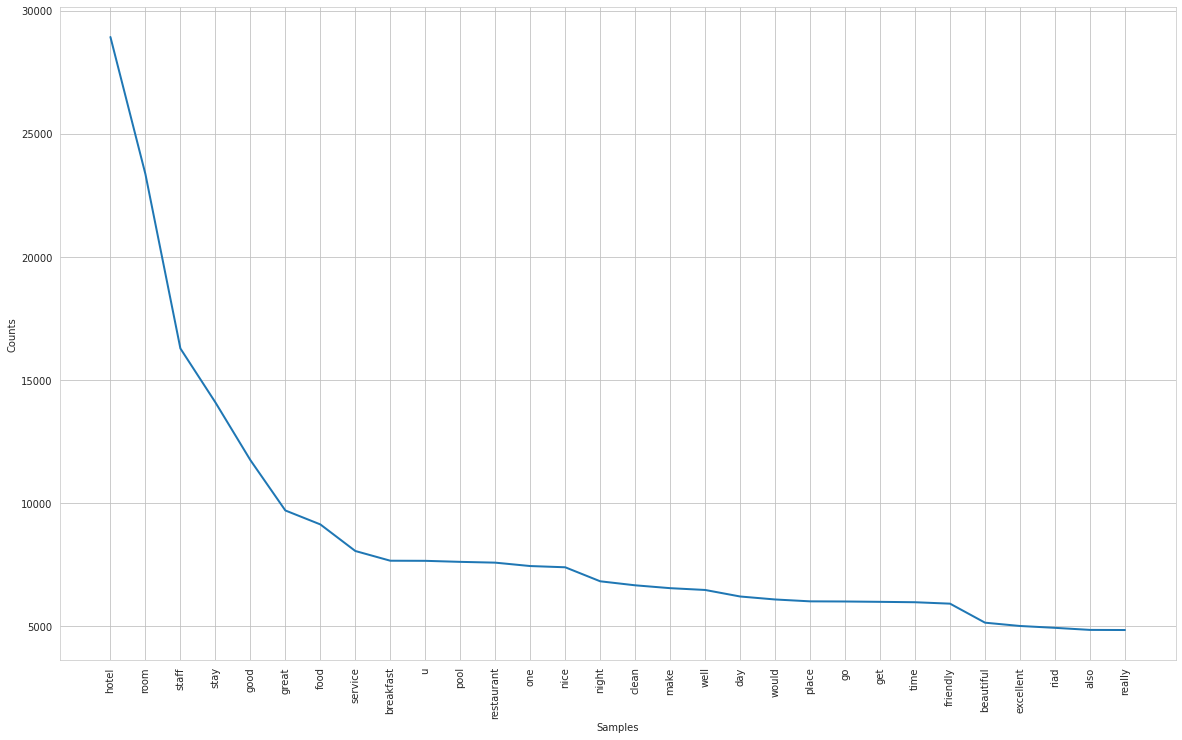

In [34]:
df['tokenized_words'] = [x.split() for x in df['tokenized']]
tokenized_words = df['tokenized_words'].to_list()

word_list = []
for x in tokenized_words:
    word_list.extend(x)
word_list
freq_dist_text = nltk.FreqDist(word_list)
plt.subplots(figsize=(20,12))
freq_dist_text.plot(30)

This frequency distribution shows which words have a higher frequency in the corpus. 

**Word Cloud**

In [35]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

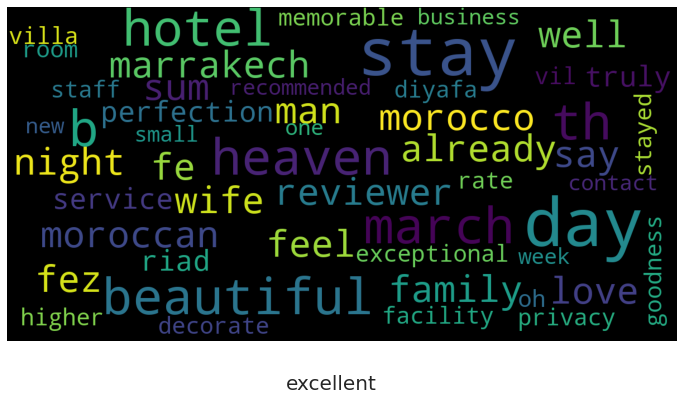

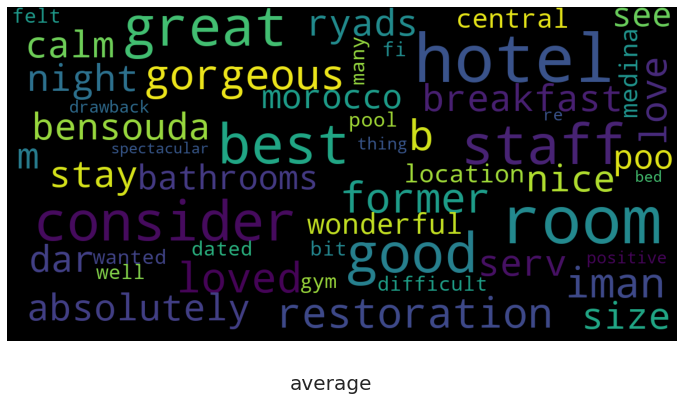

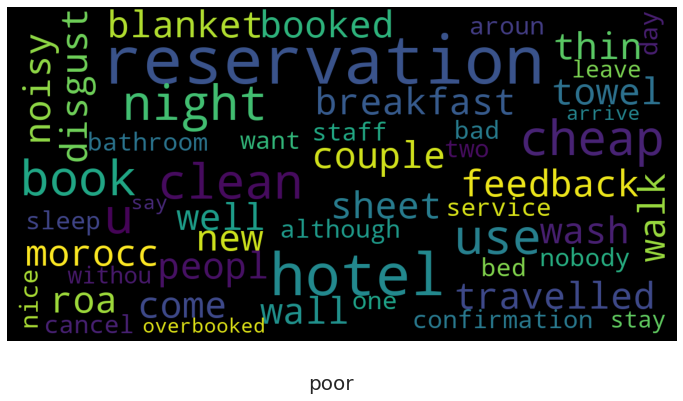

In [36]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

The word clouds above show which words appear most frequently in each category.

**Part of Speech Violin Plot**

Based on this feature to feature correlation heatmap, the character count, word count, and average length of sentence have a high correlation to each other.

# Train Test Split

In [41]:
X = df['tokenized']
y = df['new_rating']

In [42]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

# Vectorizing 

The TF-IDF Vectorizer is utilized, which takes into account how frequent a word appears in a document and also how unqiue the word is in overall corpus. In order to capture the most meaningful words, we cut off the top 20% and bottom 10% of words in the documents.

In [44]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))

In [45]:
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

In [46]:
pd.set_option('display.max_rows', None)

wm = tfidf_train.fit_transform(X_train)
tokens = tfidf_train.get_feature_names()

wm.shape
doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
data = pd.DataFrame(data=wm.toarray(), index=doc_names,
                  columns=tokens)
data.mean().sort_values()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


review         0.013438
home           0.013495
standard       0.013533
right          0.013577
long           0.013614
include        0.013647
keep           0.013869
extremely      0.013888
nothing        0.013930
morning        0.013950
quiet          0.013957
high           0.014032
away           0.014165
never          0.014245
kind           0.014350
tea            0.014355
water          0.014368
ever           0.014741
outside        0.014827
stayed         0.014854
manager        0.014889
terrace        0.014895
serve          0.014909
tour           0.015021
try            0.015069
sure           0.015072
leave          0.015139
shower         0.015197
travel         0.015233
year           0.015363
marrakech      0.015369
however        0.015371
suite          0.015418
quality        0.015437
use            0.015697
price          0.015883
top            0.015959
team           0.015962
main           0.016016
offer          0.016120
special        0.016213
quite          0

# PCA

We used PCA in order to reduce multidimensionality for some of the models to determine if results would vary. 

In [47]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [48]:
pca.n_components_

139

**PCA Visual**

In [49]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_features)

pca1 = pca_result[:,0]
pca2 = pca_result[:,1] 
pca3 = pca_result[:,2]

target = pd.Categorical(y_train).codes

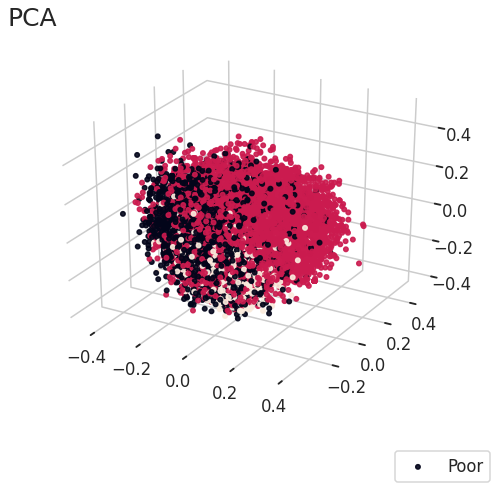

In [50]:
fig = plt.figure(figsize=(19, 7))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('PCA', fontsize=25, loc='left')
ax.scatter(xs=pca1, 
           ys=pca2, 
           zs=pca3, 
           c=target,
           alpha=.9,)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# ax.legend(['Poor','Average','Excellent'])

ax.legend(['Poor','Average','Excellent'], bbox_to_anchor=(1.02, -0.08))

#why isnt legend showing

# Modeling

We fit several different models to evaluate the compare which one outputs the highest accuracy & F1 score. In order to accurately compare each model against one another, we performed a grid-search to determine the optimal hyperparameters for each model. 

In [51]:
# create function to call for evaluation of each model

def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

### **Naive Bayes**

In [54]:
scorer = make_scorer(f1_score, average='weighted')

params=  {'alpha': [0.09, 0.1,0.11]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [55]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [56]:
nb_train_preds = grid_search_nb.best_estimator_.predict(train_features)
nb_test_preds = grid_search_nb.best_estimator_.predict(test_features)
metrics_score(nb_train_preds, y_train, nb_test_preds, y_test)

Training Accuracy:	0.6994 	Testing Accuracy:	0.6953
Training Precision:	0.7096 	Testing Precision:	0.7093
Training Recall:	0.6994 	Testing Recall:		0.6953
Training F1:		0.6301 	Testing F1:		0.6245


### **Logisitic Regression**

In [57]:
#scaling data
ss = StandardScaler()
train_scaled = ss.fit_transform(train_features)
test_scaled = ss.transform(test_features)

In [58]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

In [59]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [60]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.694 	Testing Accuracy:	0.6725
Training Precision:	0.7521 	Testing Precision:	0.7309
Training Recall:	0.694 	Testing Recall:		0.6725
Training F1:		0.7114 	Testing F1:		0.6902


### **Logisitic Regression with PCA**

In [61]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR_pca = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                                  cv = 3, n_jobs = -1, verbose = 2)

In [62]:
grid_search_LR_pca.fit(pca_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [63]:
lr_train_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_train)
lr_test_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_test)
metrics_score(lr_train_preds_pca, y_train, lr_test_preds_pca, y_test)

Training Accuracy:	0.6862 	Testing Accuracy:	0.6689
Training Precision:	0.7479 	Testing Precision:	0.7308
Training Recall:	0.6862 	Testing Recall:		0.6689
Training F1:		0.7051 	Testing F1:		0.6882


### **Decision Tree**

In [64]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [65]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [66]:
dt_train_preds = grid_search_DT.best_estimator_.predict(train_features)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_features)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)


Training Accuracy:	0.7586 	Testing Accuracy:	0.6679
Training Precision:	0.7641 	Testing Precision:	0.6406
Training Recall:	0.7586 	Testing Recall:		0.6679
Training F1:		0.7303 	Testing F1:		0.6323


### **Decision Tree with PCA**

In [67]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT_pca = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                                  cv = 5, n_jobs = -1, verbose = 2)

In [68]:
grid_search_DT_pca.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [69]:
dt_train_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_train)
dt_test_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_test)
metrics_score(dt_train_preds_pca, y_train, dt_test_preds_pca, y_test)

Training Accuracy:	0.7313 	Testing Accuracy:	0.7107
Training Precision:	0.7196 	Testing Precision:	0.6946
Training Recall:	0.7313 	Testing Recall:		0.7107
Training F1:		0.7213 	Testing F1:		0.6989


### **Random Forest**

In [70]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)


In [71]:
grid_search_RF.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [72]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_features)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_features)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.6952 	Testing Accuracy:	0.6786
Training Precision:	0.7579 	Testing Precision:	0.7177
Training Recall:	0.6952 	Testing Recall:		0.6786
Training F1:		0.6098 	Testing F1:		0.5819


### **Light GBM**

In [73]:
lgbm = LGBMClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15, 20],
              'num_leaves': [50, 100,],
              'min_split_gain': [0.3,0.4],
              'reg_alpha': [1.0, 1.1],
             'objective': ['multiclass'],
             'num_class':[3],
              'class_label':['weight']
             }

              
grid_lgbm = GridSearchCV(lgbm, param_grid, cv=2, verbose=1, n_jobs=-1)

In [ ]:
grid_lgbm.fit(train_features, y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


In [ ]:
gbm_train_preds = grid_lgbm.best_estimator_.predict(train_features)
gbm_test_preds = grid_lgbm.best_estimator_.predict(test_features)
metrics_score(gbm_train_preds, y_train, gbm_test_preds, y_test)

Training Accuracy:	0.9143 	Testing Accuracy:	0.6863
Training Precision:	0.9146 	Testing Precision:	0.6865
Training Recall:	0.9143 	Testing Recall:		0.6863
Training F1:		0.9142 	Testing F1:		0.6846


### **KNN**

In [ ]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['eucilidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, params, verbose = 1,
                        cv = 3, n_jobs =-1)


In [ ]:
grid_knn.fit(train_scaled, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 10.1min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['eucilidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [ ]:
knn_train_preds = grid_knn.best_estimator_.predict(train_scaled)
knn_test_preds = grid_knn.best_estimator_.predict(test_scaled)
metrics_score(knn_train_preds, y_train, knn_test_preds, y_test)

Training Accuracy:	0.6193 	Testing Accuracy:	0.5506
Training Precision:	0.6629 	Testing Precision:	0.5856
Training Recall:	0.6193 	Testing Recall:		0.5506
Training F1:		0.5938 	Testing F1:		0.5136


# Model Evaluation

In [ ]:
model_candidates = [
    
    {'name':'Naive Bayes',
     'accuracy score':accuracy_score(y_test, nb_test_preds),
     'f1 score':metrics.f1_score(y_test, nb_test_preds, average='weighted')},
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lr_test_preds),
     'f1 score':metrics.f1_score(y_test, lr_test_preds, average='weighted')},
    
    {'name':'Logistic Regression (PCA)',
     'accuracy score':accuracy_score(y_test, lr_test_preds_pca),
    'f1 score':metrics.f1_score(y_test, lr_test_preds_pca, average='weighted')},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dt_test_preds),
     'f1 score':metrics.f1_score(y_test, dt_test_preds, average='weighted')},
    
    {'name':'Decision Tree (PCA)',
     'accuracy score':accuracy_score(y_test, dt_test_preds_pca),
     'f1 score':metrics.f1_score(y_test, dt_test_preds_pca, average='weighted')},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'f1 score':metrics.f1_score(y_test, rf_test_preds, average='weighted')},
    
    {'name':'Light GBM',
     'accuracy score':accuracy_score(y_test, gbm_test_preds),
     'f1 score':metrics.f1_score(y_test, gbm_test_preds, average='weighted')},
    
    {'name':'KNN',
     'accuracy score':accuracy_score(y_test, knn_test_preds),
    'f1 score':metrics.f1_score(y_test, knn_test_preds, average='weighted')}
 
]

In [ ]:
final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

,accuracy score,f1 score
name,,
Naive Bayes,0.644060,0.628705
Logistic Regression,0.677238,0.674711
Logistic Regression (PCA),0.689192,0.687134
Decision Tree,0.558429,0.549373
Decision Tree (PCA),0.617224,0.613319
Random Forest,0.616248,0.590297
Light GBM,0.686265,0.684575
KNN,0.550622,0.513557


The Logistic Regression model has the highest accuracy and F1 score.

### **Confusion Matrices for Top 3 Models**

[Text(0, 0.5, 'Average'), Text(0, 1.5, 'Excellent'), Text(0, 2.5, 'Poor')]

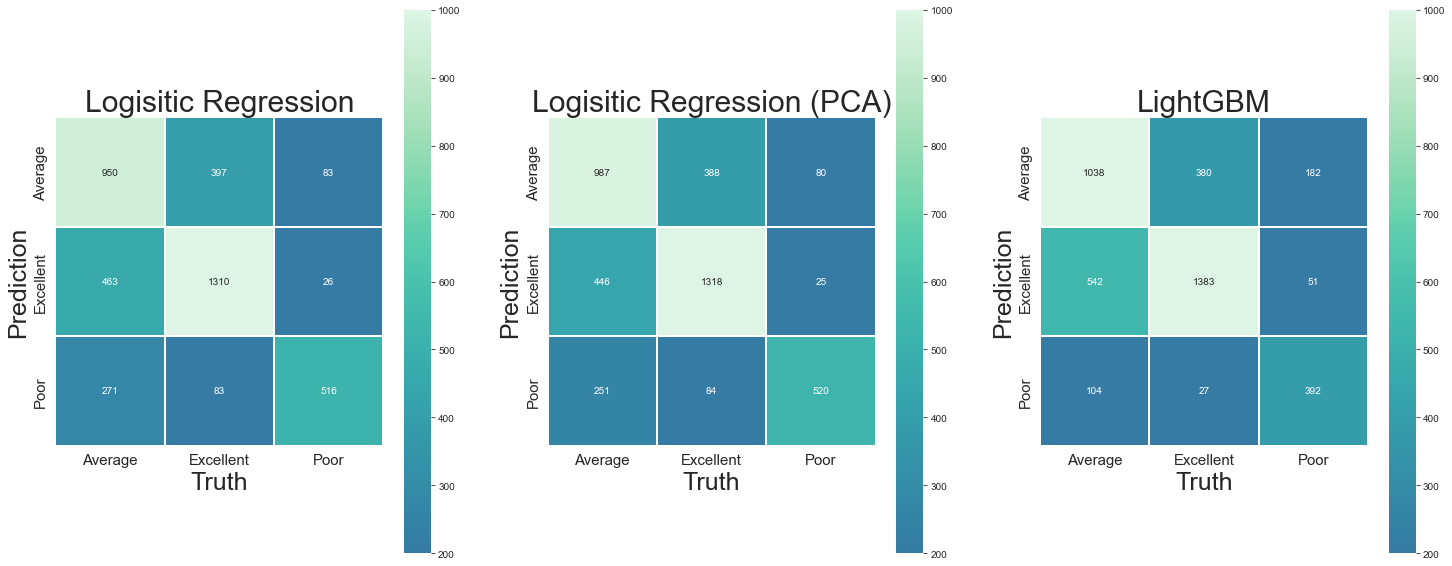

In [ ]:
sns.color_palette("viridis", as_cmap=True)
# sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# plot logistic regression confusion matrix
sns.heatmap(confusion_matrix(y_test, lr_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[0]).set_title('Logisitic Regression', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[0].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot logistic with PCA confusion matrix
sns.heatmap(confusion_matrix(y_test, lr_test_preds_pca).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[1]).set_title('Logisitic Regression (PCA)', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[1].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot LightGBM confusion matrix
sns.heatmap(confusion_matrix(y_test, gbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[2]).set_title('LightGBM', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[2].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

The logistic regression model did the best at identifying the 'poor' reviews, where 'average' and 'excellent' were relatively similar across the three models. Therefore, the logistic regression model is our final model. 